#### Setup

In [23]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import requests
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from td.client import TDClient
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set_theme()

In [2]:
pd.set_option('display.max_columns',None)

In [137]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

# Dataset

### Title: Contraceptive Method Choice  

#### Sources

1. Origin:  This dataset is a subset of:  
  
                 the 1987 National Indonesia  
                Contraceptive Prevalence Survey  
                  

2. Creator: Tjen-Sien Lim (limt@stat.wisc.edu)  
3. Donor:   Tjen-Sien Lim (limt@stat.wisc.edu)  
4. Date:    June 7, 1997

#### Past Usage

Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of
   Prediction Accuracy, Complexity, and Training Time of Thirty-three
   Old and New Classification Algorithms. Machine Learning. Forthcoming.  
   (ftp://ftp.stat.wisc.edu/pub/loh/treeprogs/quest1.7/mach1317.pdf or
   (http://www.stat.wisc.edu/~limt/mach1317.pdf)

### Description

This dataset is a subset of the 1987 National Indonesia Contraceptive
   Prevalence Survey. The samples are married women who were either not 
   pregnant or do not know if they were at the time of interview. The 
   problem is to predict the current contraceptive method choice 
   (no use, long-term methods, or short-term methods) of a woman based 
   on her demographic and socio-economic characteristics.  

- Number of Instances: 1473  
- Number of Attributes: 10 (including the class attribute)  

#### Attributes

       1. Wife's age                 | (numerical)       |
       2. Wife's education           | (categorical)     | 1=low, 2, 3, 4=high
       3. Husband's education        | (categorical)     | 1=low, 2, 3, 4=high
       4. Number of children         | (numerical)       |
       5. Wife's religion            | (binary)          | 0=Non-Islam, 1=Islam
       6. Wife's now working?        | (binary)          | 0=Yes, 1=No
       7. Husband's occupation       | (categorical)     | 1, 2, 3, 4
       8. Standard-of-living index   | (categorical)     | 1=low, 2, 3, 4=high
       9. Media exposure             | (binary)          | 0=Good, 1=Not good
             -------------------     |     ---------     |     ----------
       10. Contraceptive method used | (class attribute) |  1=No-use  
                                                            2=Long-term Method 
                                                            3=Short-term Method 
  
- Missing Attribute Values: None  

# Cleaning

The following categories will be one hot encoded:
- Wife's education — `edu`
- Husband's education — `hus_edu`
- Husband's ocupation — `hus_occu`
- Standard-of-living index — `sol`

In [ ]:
# Cleaning: setting age minimum to cap at 18
df['age'] = np.where(df.age < 18,
                    18,
                    df.age)

# FE: creating a feature that represents a binary for if wife's education is higher than husband's

df['wife_edu_betterthan_spouse'] = np.where(df[''])


#### One Hot Encoding

In [ ]:

# FE: dummy wife's education categories

df = pd.get_dummies(df, columns=['ed'], drop_first=True)

# FE: dummying husband's education categories

df = pd.get_dummies(df, columns=['hus_edu'], drop_first=True)

# FE: dummying husband's occupation categories

df = pd.get_dummies(df, columns=['hus_ocu'], drop_first=True)

# FE: dummying Standard-of-living index categories

df = pd.get_dummies(df, columns=['sol'], drop_first=True)

# possible cleaning... should we switch

# EDA

In [16]:
df.columns

Index(['age', 'ed', 'hus_edu', 'chil', 'rel', 'work', 'hus_ocu', 'sol',
       'media', 'cm'],
      dtype='object')

#### Initial

In [5]:
df

,age,ed,hus_edu,chil,rel,work,hus_ocu,sol,media,cm
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [138]:
df.isna().sum()

age        0
edu        0
hus_edu    0
chil       0
rel        0
work       0
hus_ocu    0
sol        0
media      0
cmc        0
dtype: int64

In [140]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

Questions:  
ad spending or government spending on health education, to better target demographics who are not likely to use short or long-term contraceptive methods  
each row represents a person  
target variable is contraceptive method

#### TARGET — Contraceptive Method Used — `cmc`

- **Note:** Long-term methods are male or female sterilization, Norplant$_1$ and IUD, while temporary are all others$_2$.
1. Levonorgestrel-releasing implant
2. All methods in survey:
  
        Any method          |  Male sterilization  | Injection
        Pill                | Female sterilization | Diaphragm/foam/jelly 
        Periodic abstinence |       NorpLant       | Condom
        Number of children  |         IUD          | Withdrawal
        Other               |                      | 

#### Wife's Age — `age`

- The distribution of wives who use no contraception is bimodal, with most in that category aggregating around 25 or 46.  
- The distribution of wives who report long-term contraception use centers around 35.  
- The distribution of wives who report short-term contraception use is right-skewed, with a sharp increase to the mode around age 26, then a steady, tapered decline with age.
- I might have Freudian slipped right in to choosing the most Georgia O'Keefe plotting style.
- Setting a minimum cap where we impute values below 18 or 19 to that minimum could manage lower sample sizes.

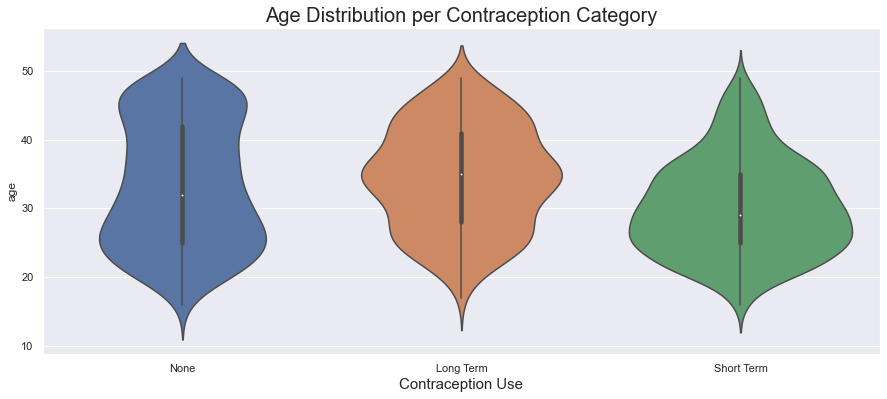

In [33]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Age Distribution per Contraception Category', size = 20)
sns.violinplot(x= df.cm, y=df.age, orient='v')
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'])
ax.set_xlabel('Contraception Use', size=15)
plt.show();

In [123]:
df[df.age > 45].age.value_counts()

47    43
48    30
49    23
46    22
Name: age, dtype: int64

In [102]:
df[df.age < 21].age.value_counts()

20    28
19    18
17     8
18     7
16     3
Name: age, dtype: int64

#### Wife's Education — `edu`

- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

In [141]:
df.edu.value_counts()

4    577
3    410
2    334
1    152
Name: edu, dtype: int64

#### Husband's Education — `hus_edu`

- 1 — did not go to school  
- 2 — some primary school  
- 3 — graduated from primary school with no further education  
- 4 — secondary or higher education. 

In [43]:
df.hus_edu.value_counts()

4    899
3    352
2    178
1     44
Name: hus_edu, dtype: int64

#### Number of Children — `chil`

- all distributions are right-skewed
- cap outliers

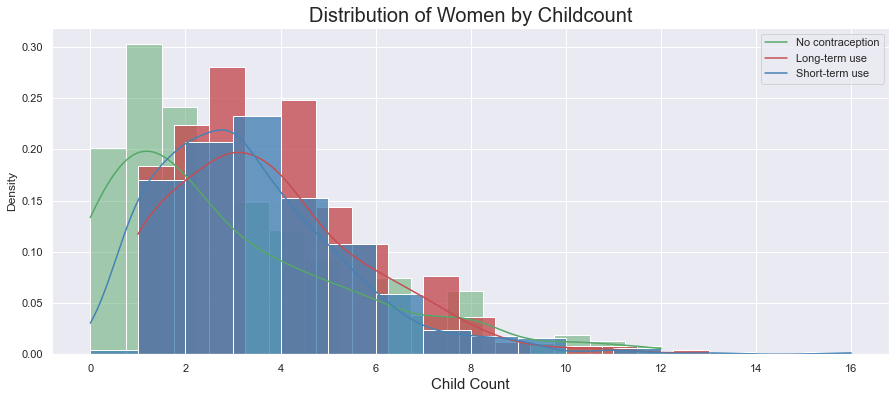

In [122]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of Women by Childcount', size = 20)
sns.histplot(x = df[df.cm == 1].chil, bins = 16, kde = True, stat = 'density', color = 'g')
sns.histplot(x = df[df.cm == 2].chil, bins = 16, kde = True, stat = 'density', color = 'r', alpha = .8)
sns.histplot(x = df[df.cm == 3].chil, bins = 16, kde = True, stat = 'density', color = 'steelblue', alpha = .8)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Long-term use', 'Short-term use'])
plt.show();

In [63]:
df[df.chil > 9].chil.value_counts()

11    11
10    11
12     4
13     2
16     1
Name: chil, dtype: int64

In [142]:
df[df.chil > 9 ].cmc.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3])

#### Wife's Religion — `rel`

- 1 = Islam
- 0 = Non-Islam

ValueError: cannot copy sequence with size 629 to array axis with dimension 10

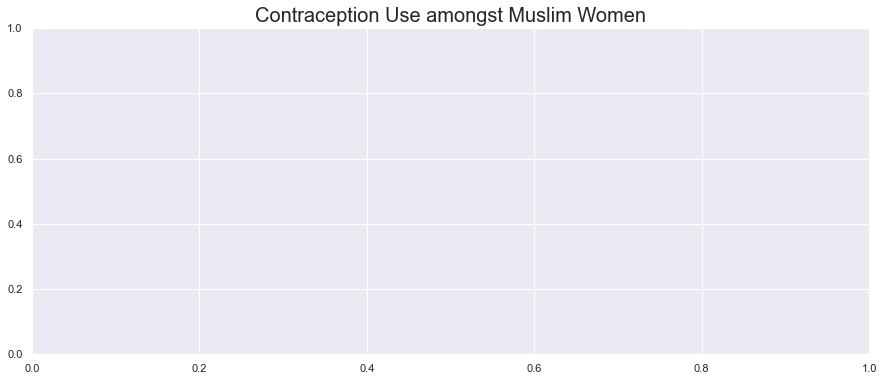

In [69]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraception Use amongst Muslim Women', size = 20)
sns.barplot(x = [df[df.cmc == 1], df[df.cmc == 2], df[df.cmc == 3]], y = df.cmc.value_counts(), hue = df.rel, scale_hue = False)
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'])
ax.set_xlabel('Contraception Use', size=15)
plt.show();

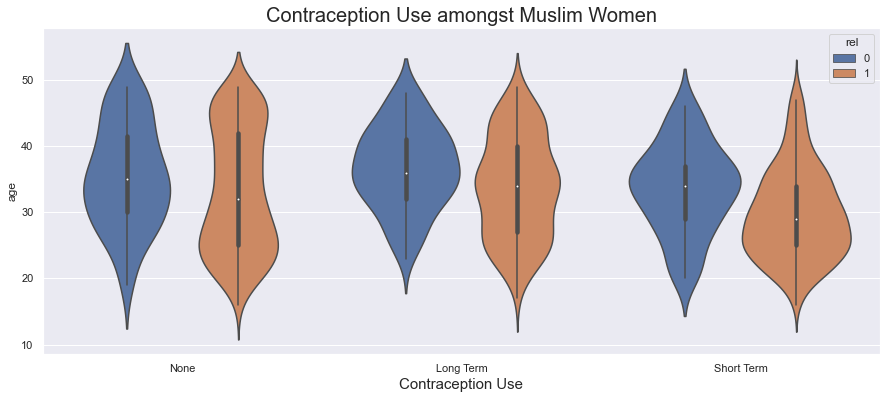

In [68]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Contraception Use amongst Muslim Women', size = 20)
sns.violinplot(x = df.cmc, y = df.age, orient = 'v', hue = df.rel, scale_hue = False)
plt.xticks(np.arange(3), ['None', 'Long Term', 'Short Term'])
ax.set_xlabel('Contraception Use', size=15)
plt.show();

In [105]:
df[df.rel == 1].cmc.value_counts()

1    554
3    442
2    257
Name: cm, dtype: int64

In [66]:
df.rel.value_counts()

1    1253
0     220
Name: rel, dtype: int64

#### Wife's Current Emplyment Status — `work`

- binary categorical. Imbalanced by about: 1:3  
- 1 — No
- 0 — Yes

In [71]:
df.work.value_counts()

1    1104
0     369
Name: work, dtype: int64

In [143]:
df[(df.work == 1) & (df.cmc == 1)].cmc.value_counts()

1    459
Name: cmc, dtype: int64

In [144]:
df[(df.work == 1) & (df.cmc == 3)].cmc.value_counts()

3    401
Name: cmc, dtype: int64

In [145]:
df[(df.work == 1) & (df.cmc == 2)].cmc.value_counts()

2    244
Name: cmc, dtype: int64

In [146]:
df[(df.work == 0) & (df.cmc == 1)].cmc.value_counts()

1    170
Name: cmc, dtype: int64

In [147]:
df[(df.work == 0) & (df.cmc == 3)].cmc.value_counts()

3    110
Name: cmc, dtype: int64

In [148]:
df[(df.work == 0) & (df.cmc == 2)].cmc.value_counts()

2    89
Name: cmc, dtype: int64

In [149]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

''

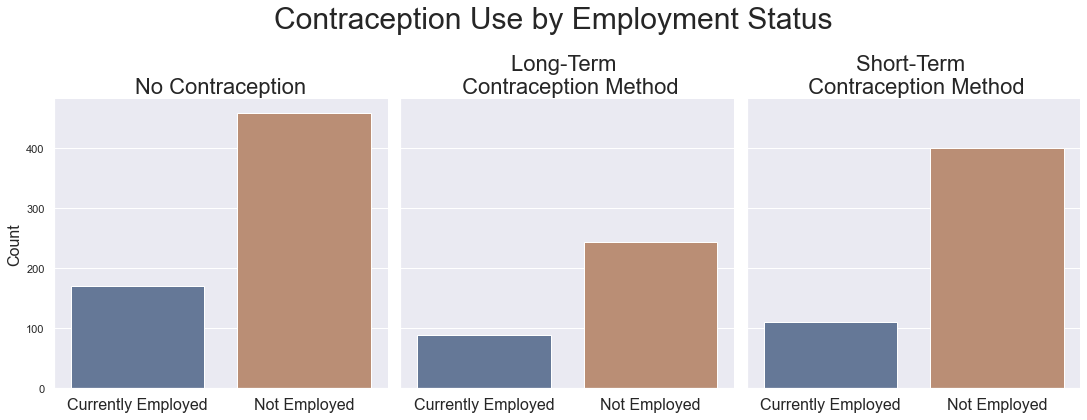

In [214]:
df_work_copy = df.copy()
df_work_copy['cmc'] = df_work_copy['cmc'].map({
    1: "No Contraception", 
    2: "Long-Term \n Contraception Method", 
    3: "Short-Term \n Contraception Method"})
g = sns.catplot(x="work", col="cmc", col_wrap=3,
            data=df_work_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Currently Employed', 'Not Employed'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Employment Status', size = 30, y=1.15)
)
;

#### Husband's Occupation — `hus_ocu`

- 1 — PROFESSIONAL, TECHNICAL AND CLERICAL
- 2 — SALES, SERVICES
- 3 — MANUAL 
- 4 — AGRICULTURE
- 5 — OTHER

- ~~Impute `4` values to 3.~~  
  - Ignore above. Numerical values for this category are in fact **categorical** and must be dummied. 
  - While it is confusing as to which number truly represents which category in our dataset (as we are missing one number listed in the survey), there is no need to impute.

In [72]:
df.hus_ocu.value_counts()

3    585
1    436
2    425
4     27
Name: hus_ocu, dtype: int64

#### Standard-of-living Index — `sol`

- review standard-of living index: what it is and what the values may represent.

In [74]:
df.sol.value_counts()

4    684
3    431
2    229
1    129
Name: sol, dtype: int64

In [ ]:
df_work_copy = df.copy()
df_work_copy['cmc'] = df_work_copy['cmc'].map({
    1: "No Contraception", 
    2: "Long-Term \n Contraception Method", 
    3: "Short-Term \n Contraception Method"})
g = sns.catplot(x="work", col="cmc", col_wrap=3,
            data=df_work_copy, saturation=.5,
            kind="count", height=5, aspect=1)
(g.set_axis_labels("", "Count", size=16)
  .set_xticklabels(['Currently Employed', 'Not Employed'], size=16)
  .set_titles('{col_name}', size=22)
  .fig.suptitle('Contraception Use by Employment Status', size = 30, y=1.15)
)
;

#### Media Exposure —`media`

- Binary categorical. Class imbalance of about: 13:1
- A great majority of women in this survey have good media exposure.
- According to the survey, the qualifiers for having "good" media exposure is as follows:  
  
      Ever-married women who usually read a newspaper once a week, watch television once a week, or listen to a radio daily by background characteristics, NICPS, 1987  
  
- 0 — Good
- 1 — Not good

In [75]:
df.media.value_counts()

0    1364
1     109
Name: media, dtype: int64

#### Pair Plots

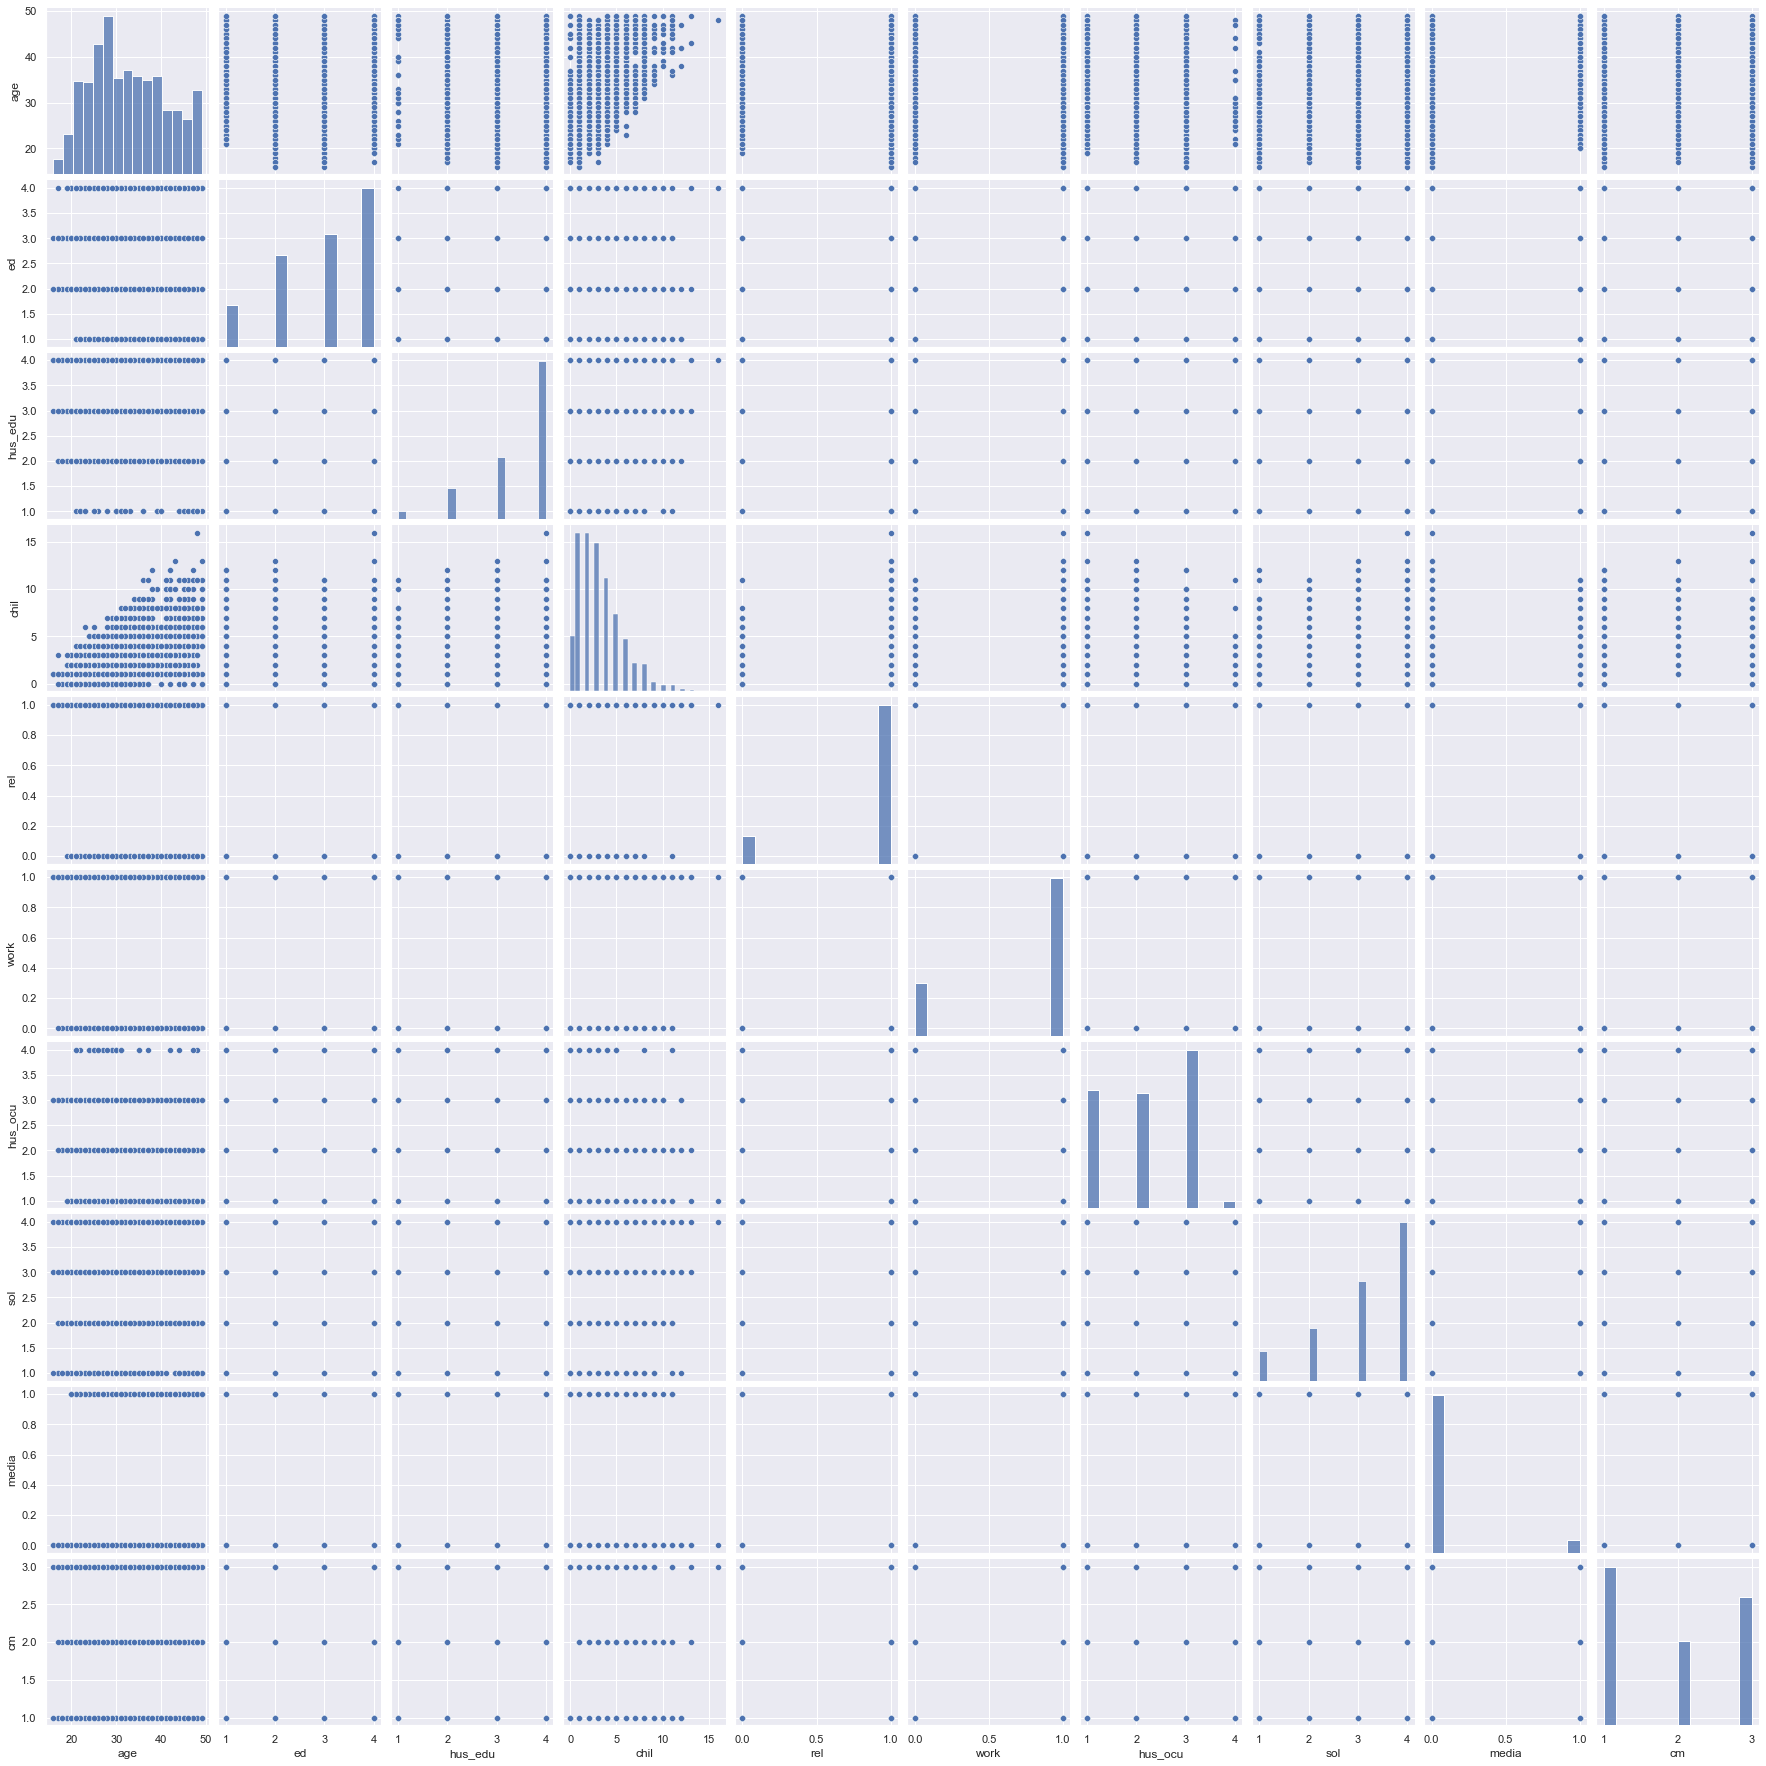

In [7]:
sns.pairplot(df);

### Statistical Tests

Reference:

We will take a look at the following with statistical tests:

whether women tend to have have a different contraceptive use .
Method: two sample, paired t-test
whether or not there is a difference between the mean property sale price for properties that are within Seattle city limits, in the suburbs of Seattle, and further out in the rural parts of King County.
Method: ANOVA f-test with 3 samples.
whether or not the season that a property sale occurred has a statistically significant impact on sale price.
Method: ANOVA f-test with 4 samples.

## Further Research

In [106]:
addtl = pd.read_csv('data/variables-03-30-21-034145.csv')
addtl

,survey_idno,sid,file_id,vid,name,labl,var_intrvl,var_dcml,var_wgt,var_start_pos,var_end_pos,var_width,var_imputation,var_security,var_respunit,var_qstn_preqtxt,var_qstn_qstnlit,var_qstn_postqtxt,var_qstn_ivulnstr,var_universe,var_sumstat,var_txt,var_catgry,var_codinstr,var_concept,var_format,var_notes
0,IDN_1987_DHS_v01_M,1398,F5,V80,caseid,Case identification,discrete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],NaN,[],"{""type"":""character"",""schema"":""other"",""category...",NaN


In [107]:
birth_var = pd.read_csv('data/variables-03-30-21-034408.csv')
birth_var

,survey_idno,sid,file_id,vid,name,labl,var_intrvl,var_dcml,var_wgt,var_start_pos,var_end_pos,var_width,var_imputation,var_security,var_respunit,var_qstn_preqtxt,var_qstn_qstnlit,var_qstn_postqtxt,var_qstn_ivulnstr,var_universe,var_sumstat,var_txt,var_catgry,var_codinstr,var_concept,var_format,var_notes
0,IDN_1987_DHS_v01_M,1398,F5,V81,bidx,Birth column number,discrete,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],NaN,[],"{""type"":""numeric"",""schema"":""other"",""category"":...",NaN


In [109]:
xml = read_xml('.xml')

NameError: name 'read_xml' is not defined

In [111]:
import xml.etree.ElementTree as ET

xml_data = open('data/IDN_1987_DHS_v01_M.xml', 'r').read()  # Read file
root = ET.XML(xml_data)  # Parse XML

data = []
cols = []
for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])
    cols.append(child.tag)

xml_df = pd.DataFrame(data).T  # Write in DF and transpose it
xml_df.columns = cols  # Update column names
xml_df

,{http://www.icpsr.umich.edu/DDI}docDscr,{http://www.icpsr.umich.edu/DDI}stdyDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}fileDscr,{http://www.icpsr.umich.edu/DDI}dataDscr
0,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n,\n
1,None,\n,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n This data dictionary was generated fro...,\n
2,None,\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
3,None,\n,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
371,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
372,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n
373,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,\n


# Feature Engineering

# Modeling

In [ ]:
logreg_model_final = LogisticRegression(random_state=20,
                                        solver="liblinear", C=.001, class_weight = 'balanced')